In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import os

C:\Users\user\AppData\Local\Temp\ipykernel_11472\806035556.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
train_dataset_path = "F:\\archive\\data\\puzzle_2x2\\train\\"
train_label_path = "F:\\archive\\data\\puzzle_2x2\\train_filtered.csv"

test_dataset_path = "F:\\archive\\data\\puzzle_2x2\\test\\"
test_label_path = "F:\\archive\\data\\puzzle_2x2\\test.csv"

validation_dataset_path = "F:\\archive\\data\\puzzle_2x2\\valid\\"
validation_label_path = "F:\\archive\\data\\puzzle_2x2\\valid.csv"

def load_data(dataset_path, label_path, percentage=100):
    df = pd.read_csv(label_path)
    images = []
    labels = []

    # Select a subset of data based on the percentage
    num_samples = int(len(df) * (percentage / 100))
    df = df.head(num_samples)

    for index, row in df.iterrows():
        image_name = row['image']  # Get the image name from the dataframe
        image_path = os.path.join(dataset_path, image_name)  # Construct the full image path
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)

        # Convert label permutation to integer index
        label_permutation = [int(x) for x in row['label'].split()]
        label_index = get_permutation_index(label_permutation)
        
        labels.append(label_index)

    return np.array(images), np.array(labels)

def get_permutation_index(perm):
    # Define all possible permutations of [0, 1, 2, 3]
    permutations = [
        [0, 1, 2, 3], [0, 1, 3, 2], [0, 2, 1, 3], [0, 2, 3, 1],
        [0, 3, 1, 2], [0, 3, 2, 1], [1, 0, 2, 3], [1, 0, 3, 2],
        [1, 2, 0, 3], [1, 2, 3, 0], [1, 3, 0, 2], [1, 3, 2, 0],
        [2, 0, 1, 3], [2, 0, 3, 1], [2, 1, 0, 3], [2, 1, 3, 0],
        [2, 3, 0, 1], [2, 3, 1, 0], [3, 0, 1, 2], [3, 0, 2, 1],
        [3, 1, 0, 2], [3, 1, 2, 0], [3, 2, 0, 1], [3, 2, 1, 0]
    ]
    # Find the index of the given permutation in the list of permutations
    index = permutations.index(perm)
    return index


In [3]:
# Example usage:
train_images, train_labels = load_data(train_dataset_path, train_label_path, percentage=100)
test_images, test_labels = load_data(test_dataset_path, test_label_path, percentage=100)
validation_images, validation_labels = load_data(validation_dataset_path, validation_label_path, percentage=100)
print(train_labels.shape)

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0

(21600,)


In [5]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Model Checkpoint
checkpoint = ModelCheckpoint('best_multilayer_model.h5', monitor='val_accuracy', save_best_only=True)

# Define the multilayer neural network model
model = models.Sequential([
    layers.Flatten(input_shape=(100, 100, 3)),  # Flatten the input images
    layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(2048, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(24, activation='softmax')  # Output layer
])


# Compile the model with RMSprop optimizer and categorical cross-entropy loss
model.compile(optimizer=RMSprop(learning_rate=0.001),  # RMSprop optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy
              metrics=['accuracy'])

# Train the model with batch normalization, dropout, and RMSprop optimizer
history = model.fit(
    train_images, train_labels, 
    batch_size=256,
    epochs=50,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping, checkpoint],
    verbose=1)

# Evaluate the model on test data 
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Save the final model
model.save('final_multilayer_model.h5')

# Load the best model
best_model = models.load_model('best_multilayer_model.h5')

# Evaluate the best model
best_model_loss, best_model_acc = best_model.evaluate(test_images, test_labels)

# Predict labels for test data
predictions = best_model.predict(test_images)
predicted_permutations = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each sample


Epoch 1/50
85/85 [==============================] - 164s 2s/step - loss: 14.9944 - accuracy: 0.0418 - val_loss: 14.4554 - val_accuracy: 0.0338
Epoch 2/50
85/85 [==============================] - 154s 2s/step - loss: 9.2632 - accuracy: 0.0459 - val_loss: 7.1037 - val_accuracy: 0.0519
Epoch 3/50
85/85 [==============================] - 149s 2s/step - loss: 6.2946 - accuracy: 0.0584 - val_loss: 5.3407 - val_accuracy: 0.0701
Epoch 4/50
85/85 [==============================] - 148s 2s/step - loss: 4.9286 - accuracy: 0.0904 - val_loss: 4.6013 - val_accuracy: 0.0909
Epoch 5/50
85/85 [==============================] - 136s 2s/step - loss: 4.2351 - accuracy: 0.1127 - val_loss: 4.1790 - val_accuracy: 0.0649
Epoch 6/50
85/85 [==============================] - 137s 2s/step - loss: 3.8427 - accuracy: 0.1171 - val_loss: 4.0185 - val_accuracy: 0.0753
Epoch 7/50
85/85 [==============================] - 136s 2s/step - loss: 3.6064 - accuracy: 0.1233 - val_loss: 3.8067 - val_accuracy: 0.0909
Epoch 8/50


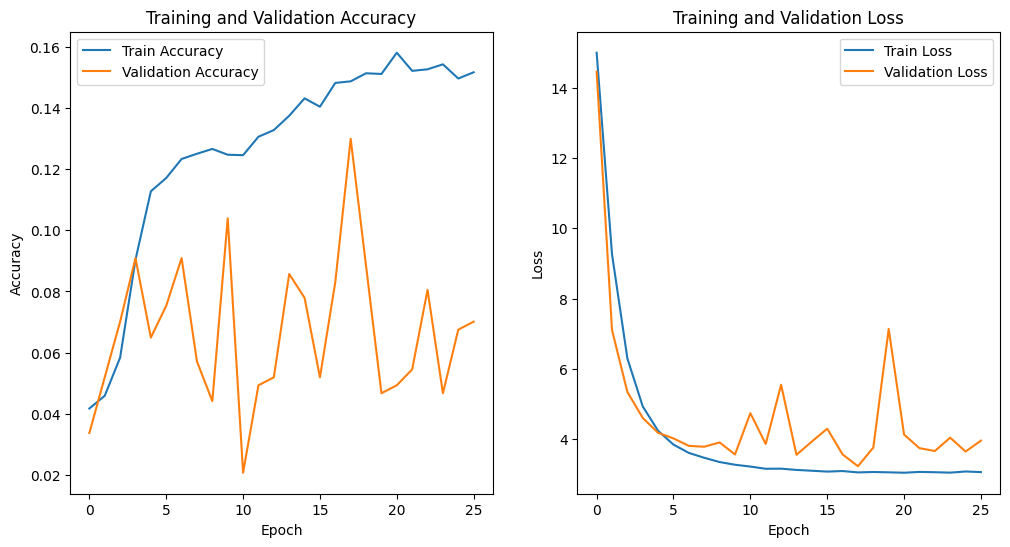

In [6]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plots
plt.savefig('multilayer_training_plots.png')

# Write final testing accuracy to a text file
with open('multilayer_testing_accuracy.txt', 'w') as f:
    f.write('Final Test accuracy: {:.4f}\n'.format(test_acc))
    f.write('Best Model Test accuracy: {:.4f}\n'.format(best_model_acc))